https://blog.csdn.net/u014514939/article/details/89410425?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_baidulandingword~default-0.control&spm=1001.2101.3001.4242

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import jieba
from nltk.translate.bleu_score import sentence_bleu
from opencc import OpenCC

# 处理英文句子 加上标记 
def preprocess_english_sentence(w):
    w = w.lower().strip()
    # 在单词与跟在其后的标点符号之间插入一个空格
    # "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    
    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w
# 处理中文繁体字 加上标记 
def preprocess_chinese_sentence(w):
    # 将句子里的繁体中文转化为简体中文
    w = OpenCC('t2s').convert(w)
    # 分词
    ws = [i for i in jieba.cut(w)]
    w = ' '.join(ws)
    
    # 给句子加上开始和结束标记，以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

# 数据读取 + 调用函数读取！ 
def read_data(path):
    english=[]
    chinese=[]
    with open(path,encoding='utf-8') as f:
        for line in tqdm(f):
            eng_one=line.split('\t')[0]
            eng_one=preprocess_english_sentence(eng_one)
            chin_one=line.split('\t')[1]
            chin_one= preprocess_chinese_sentence(chin_one)
            english.append(eng_one)
            chinese.append(chin_one)
    return english,chinese
target_eng,input_chin=read_data("cmn.txt")
print(target_eng[-1])
print(input_chin[-1])

0it [00:00, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wang\AppData\Local\Temp\jieba.cache
Loading model cost 1.252 seconds.
Prefix dict has been built successfully.
26388it [01:40, 263.13it/s]

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如果 一个 人 在 成人 前 没有 机会 习得 目标语言 ， 他 对 该 语言 的 认识 达到 母语 者 程度 的 机会 是 相当 小 的 。 <end>


In [3]:
# 把句子转化成 数字表示的形式 
def creat_tokenize_padd(list_data): # 传入一个列表就好了！！！！
    # 初始化Tokenizer，之前已经对句子做了预处理，这里直接按照空格将每个token切分出来
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    # 对目标语言数据集进行tokenize
    tokenizer.fit_on_texts(list_data)
    # 将文本序列转化为编码序列
    tensor = tokenizer.texts_to_sequences(list_data)
    # 把所有句子补齐
    t_tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=38)# 
    return t_tensor,tokenizer
input_chin_tensor,input_chin_tokenizer=creat_tokenize_padd(input_chin)
target_eng_tensor,target_eng_tokenizer=creat_tokenize_padd(target_eng)

In [4]:
MAX_INPUT_LENGTH = max([len(i) for  i in input_chin_tensor])
MAX_OUTPUT_LENGTH = max([len(i) for  i in target_eng_tensor])
print("输入句子的最大长度：", MAX_INPUT_LENGTH)
print("输出句子的最大长度：", MAX_OUTPUT_LENGTH)
print(input_chin_tensor[-1])
print(target_eng_tensor[-1])
print(type(input_chin_tensor))
print(input_chin_tensor.shape)
print(type(target_eng_tensor))
print(target_eng_tensor.shape)


target_index_word = target_eng_tokenizer.index_word
target_word_index = target_eng_tokenizer.word_index
input_index_word = input_chin_tokenizer.index_word
input_word_index = input_chin_tokenizer.word_index
print(input_word_index["我"])#测试 4 
print(input_index_word[4])  # 测试 我 
print("源语言词典大小：{}， 目标语言词典大小：{}".format(len(input_index_word), len(target_index_word)))

input_chin_tensor_train, input_chin_tensor_val,target_eng_tensor_train, target_eng_tensor_val = train_test_split(input_chin_tensor, target_eng_tensor, test_size=0.3)
print("训练集规模：{}， 测试集规模：{}".format(len(input_chin_tensor_train), len(input_chin_tensor_val)))
# 扩大训练测试 training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

输入句子的最大长度： 38
输出句子的最大长度： 38
[    1   113    28    35    11  2564   183    25   437 11932 11933    16
     8    44   128   387     5   213  2243   827  1017  2684     5   437
    12   846   365     5     3     2     0     0     0     0     0     0
     0     0]
[   1   81    8  292   50   41   70    8  570    6 6755   35 2504  470
   71    5   56   13   16   68 2784   23   13   16 1478    6   39  311
    6 1444  935 1082 1648   14   18  470    3    2]
<class 'numpy.ndarray'>
(26388, 38)
<class 'numpy.ndarray'>
(26388, 38)
4
我
源语言词典大小：11933， 目标语言词典大小：6755
训练集规模：18471， 测试集规模：7917


# EncoderRNN

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # 此处的hidden_size也是embedding_dim
        self.embedding = nn.Embedding(input_size, hidden_size) # 这个embedding的模型的定义 后边需要调用这个模型
        #               输入的这个句子中单词的个数， 是每个单词的维度定义 
        self.gru = nn.GRU(hidden_size,hidden_size)
        #                输入单词维度  输出单词维度 这里定义的输入输出是一样的 
        # 如果说加一个参数就是num_layers：lstm隐层的层数，默认为 1 
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
        
    def forward(self, input, hidden):#  hidden：torch.Size([1, 1, 256])
        # input维度为(seq_len=1,batch_size=1)
        embedded = self.embedding(input).view(1, 1, -1)
        # 经过embedded,维度为(seq_len=1,batch_size=1,embedding_dim)
        output = embedded
        
        # hidden维度为(num_layers*direction_num=1, batch_size=1, hidden_size)
        # output的维度为(seq_length=1, batch_size=1, hidden_size)
        output, hidden = self.gru(output, hidden)
        return output, hidden

# AttnDecoderRNN

In [6]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length):
        super(AttnDecoderRNN, self).__init__()
        # hidden_size也是embedding_dim 就是刚开始 每个单词的维度 
        self.hidden_size = hidden_size
        self.output_size = output_size # self.output_size:3228  调用的时候传进来的 
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) # 跟上边的一样  embedding模型的定义 
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_2 = nn.Linear(self.max_length, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size) #hidden_size=256

    def forward(self,decode_input,encoder_outputs,hidden,mask):
        # hidden维度为 hidden = encoder_hidden=torch.Size([1, 1, 256]) 
        # encoder_outputs  前边的数字向量矩阵 固定长度是10个字 torch.Size([20, 256])
        # padding_mask 是一维度的 有1 有 0
        decode_input = decode_input.view(1, -1)# torch.Size([1, 256])
        input_1=decode_input.repeat(len(encoder_outputs),1)
#         print(input_1.size())
#         print(encoder_outputs.size())
        attn_weights =torch.tanh(self.attn(torch.cat([input_1,encoder_outputs], 1)))
        attn_weights=self.attn_2(attn_weights).view(1,-1)
        index =list(mask).index(0)# 把padding 的位置是0 的注意力权重复制为0
        attn_weights[0][index:]=int(-10) # 经过F.softmax 让padding的位置 概率非常小
        attn_weights=F.softmax(attn_weights,dim=1)
#         print("attn_weights",attn_weights)
#         print("encoder_outputs",encoder_outputs.size())
        
        # torch.cat： torch.Size([10, 512]) 把两个[10,256]的tensor 拼接 
        # attn_weights维度为  torch.Size([1, 10]),tensor([[0.0988, 0.0997, 0.0944, 0.1047, 0.1051, 0.0925, 0.1062, 0.1043, 0.0892,0.1052]], device='cuda:0', grad_fn=<ViewBackward>)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))# unsqueeze(0)在第一个维度上 增加一维 1 
#         print(attn_applied.size())  # torch.Size([1, 1, 256])
        
        output = torch.cat([decode_input , attn_applied[0]], 1)
        # output.size():torch.Size([1, 512])
        
        output = self.attn_combine(output).unsqueeze(0)
        # output.size():torch.Size([1, 1, 256])
        
        output = F.relu(output)
        #output.size():torch.Size([1, 1, 256])
        
        output, hidden = self.gru(output, hidden) # 输入端hidden:torch.Size([1, 1, 256])
        # output.size()：torch.Size([1, 1, 256])，输出端hidden.size()：torch.Size([1, 1, 256]) 
        
#         output_last=self.out(output[0])                      # 我i自己改的
        output_last = F.log_softmax(self.out(output[0]), dim=1) # 原来是这个的 log_softmax
        #output.size()：torch.Size([1, 6756])
        return output_last,output, hidden, attn_weights
         

In [10]:
m=torch.zeros(32).to(device)
print(m)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [44]:
# 加入mask的情况：
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 256
vocab_input_size = len(input_word_index) + 1
vocab_target_size = len(target_word_index) + 1
max_length=38
learning_rate=0.001
epoch=1

encoder = EncoderRNN(vocab_input_size,hidden_size).to(device)  # 模型定义实例化 
attentionRNN_decoder = AttnDecoderRNN(hidden_size,vocab_target_size,max_length).to(device) # 模型定义实例化 

# encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(attentionRNN_decoder.parameters(), lr=learning_rate)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(attentionRNN_decoder.parameters(), lr=learning_rate)


criterion = nn.NLLLoss().to(device) # 交叉熵计算公式

for epo in range(epoch):
        for setence_idx,input_setence in tqdm(enumerate(input_chin_tensor_train)):
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad() 
                loss = 0
                mask=torch.zeros(max_length).to(device)# 制作msak矩阵
                input_setence=torch.LongTensor(input_setence).to(device)
                encoder_outputs = torch.zeros(max_length, hidden_size).to(device) 

                for word_inx in range(len(input_setence)):
                    hidden = encoder.initHidden().to(device)
                    encoder_output, hidden = encoder((input_setence[word_inx]), hidden) # encoder就是 EncoderRNN 模型 
                    encoder_outputs[word_inx]=encoder_output[0][0]
                    if input_setence[word_inx]!=0:
                        mask[word_inx]=1 # 让真实的单词位置mask是1  
                        
#                 print(mask)
        #-------encoder部分完成了-----------------------
#                 print("encoder部分完成了")
#                 print("encoder_outputs",encoder_outputs.size()) # torch.Size([20, 256])
                target_setence=torch.LongTensor(target_eng_tensor_train[setence_idx]).to(device)
                decoder_input=attentionRNN_decoder.initHidden().to(device)#第一输入是随机初始化的 [1,256]
        
                for  word_idx in range(len(target_setence)):
                        decoder_output,decoder_input,hidden,attn_weights = attentionRNN_decoder(decoder_input,encoder_outputs,hidden,mask)
                    
                        loss+=criterion(decoder_output.to(device), torch.LongTensor([target_setence[word_idx]]).to(device))
                        loss=loss+loss

#                 if setence_idx%100==0:# 每100次 打印一下loss
                print(setence_idx,(loss/max_length).item())
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()

#         print("第",epo,"个epoch的平均loss:",loss_epoch/len(input_chin_tensor_train))  
        torch.save(encoder.state_dict(),str(epo)+'encoder.pth')
        torch.save(attentionRNN_decoder.state_dict(),str(epo)+'attentionRNN_decoder.pth') 

# 不加入mask的情况：

In [11]:
# 不加入mask的情况：
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length):
        super(AttnDecoderRNN, self).__init__()
        # hidden_size也是embedding_dim 就是刚开始 每个单词的维度 
        self.hidden_size = hidden_size
        self.output_size = output_size # self.output_size:3228  调用的时候传进来的 
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) # 跟上边的一样  embedding模型的定义 
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_2 = nn.Linear(self.max_length, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size) #hidden_size=256

    def forward(self,decode_input,encoder_outputs,hidden,mask):
        # hidden维度为 hidden = encoder_hidden=torch.Size([1, 1, 256]) 
        # encoder_outputs  前边的数字向量矩阵 固定长度是10个字 torch.Size([20, 256])
        # padding_mask 是一维度的 有1 有 0
        decode_input = decode_input.view(1, -1)# torch.Size([1, 256])
        input_1=decode_input.repeat(len(encoder_outputs),1)
        attn_weights =torch.tanh(self.attn(torch.cat([input_1,encoder_outputs], 1)))
        attn_weights=self.attn_2(attn_weights).view(1,-1)
#         index =list(mask).index(0)# 把padding 的位置是0 的注意力权重复制为0
#         attn_weights[0][index:]=int(-10) # 经过F.softmax 让padding的位置 概率非常小
        attn_weights=F.softmax(attn_weights,dim=1)
#         print("attn_weights",attn_weights)
#         print("encoder_outputs",encoder_outputs.size())
        
        # torch.cat： torch.Size([10, 512]) 把两个[10,256]的tensor 拼接 
        # attn_weights维度为  torch.Size([1, 10]),tensor([[0.0988, 0.0997, 0.0944, 0.1047, 0.1051, 0.0925, 0.1062, 0.1043, 0.0892,0.1052]], device='cuda:0', grad_fn=<ViewBackward>)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))# unsqueeze(0)在第一个维度上 增加一维 1 
#         print(attn_applied.size())  # torch.Size([1, 1, 256])
        output = torch.cat([decode_input , attn_applied[0]], 1)
        # output.size():torch.Size([1, 512])
        output = self.attn_combine(output).unsqueeze(0)
        # output.size():torch.Size([1, 1, 256])
        output = F.relu(output)
        #output.size():torch.Size([1, 1, 256])
        output, hidden = self.gru(output, hidden) # 输入端hidden:torch.Size([1, 1, 256])
        # output.size()：torch.Size([1, 1, 256])，输出端hidden.size()：torch.Size([1, 1, 256]) 
        
#         output_last=self.out(output[0])                      # 我i自己改的
        output_last = F.log_softmax(self.out(output[0]), dim=1) # 原来是这个的 log_softmax
        #output.size()：torch.Size([1, 6756])
        return output_last,output, hidden, attn_weights


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 256
vocab_input_size = len(input_word_index) + 1
vocab_target_size = len(target_word_index) + 1
max_length=38
learning_rate=0.001
epoch=1

encoder = EncoderRNN(vocab_input_size,hidden_size).to(device)  # 模型定义实例化 
attentionRNN_decoder = AttnDecoderRNN(hidden_size,vocab_target_size,max_length).to(device) # 模型定义实例化 

# encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.SGD(attentionRNN_decoder.parameters(), lr=learning_rate)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(attentionRNN_decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss().to(device) # 交叉熵计算公式

for epo in tqdm(range(epoch)):
        for setence_idx,input_setence in enumerate(input_chin_tensor_train):
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad() 
                loss = 0
                mask=torch.zeros(max_length).to(device)# 制作msak矩阵
                input_setence=torch.LongTensor(input_setence).to(device)
                encoder_outputs = torch.zeros(max_length, hidden_size).to(device) 

                for word_inx in range(len(input_setence)):
                    hidden = encoder.initHidden().to(device)
                    encoder_output, hidden = encoder((input_setence[word_inx]), hidden) # encoder就是 EncoderRNN 模型 
                    encoder_outputs[word_inx]=encoder_output[0][0]
                    if input_setence[word_inx]!=0:
                         mask[word_inx]=1 # 让真实的单词位置mask是1  
                        
#                 print(mask)
        #-------encoder部分完成了-----------------------
#                 print("encoder部分完成了")
#                 print("encoder_outputs",encoder_outputs.size()) # torch.Size([20, 256])
                target_setence=torch.LongTensor(target_eng_tensor_train[setence_idx]).to(device)
                decoder_input=attentionRNN_decoder.initHidden().to(device)#第一输入是随机初始化的 [1,256]
        
                for  word_idx in range(len(target_setence)):
                        decoder_output,decoder_input,hidden,attn_weights = attentionRNN_decoder(decoder_input,encoder_outputs,hidden,mask)
                    
                        loss+=criterion(decoder_output.to(device), torch.LongTensor([target_setence[word_idx]]).to(device))
                        loss=loss+loss

#                 if setence_idx%100==0:# 每100次 打印一下loss
#                 print(setence_idx,(loss/max_length).item())
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()

#         print("第",epo,"个epoch的平均loss:",loss_epoch/len(input_chin_tensor_train))  
        torch.save(encoder.state_dict(),str(epo)+'nomaskencoder.pth')
        torch.save(attentionRNN_decoder.state_dict(),str(epo)+'nomaskattentionRNN_decoder.pth') 

  0%|                                                                                            | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [13]:
encoder=EncoderRNN(vocab_input_size,hidden_size).to(device)  # 模型定义实例化 
encoder.load_state_dict(torch.load('0nomaskencoder.pth'))  

attentionRNN_decoder = AttnDecoderRNN(hidden_size,vocab_target_size,max_length).to(device)
attentionRNN_decoder.load_state_dict(torch.load('0nomaskattentionRNN_decoder.pth')) # 

<All keys matched successfully>

In [14]:
def data_val(input_chin_tensor_val,target_eng_tensor_val):
        with torch.no_grad():
            for setence_idx,input_setence in tqdm(enumerate(input_chin_tensor_val)):
                loss = 0
                input_setence=torch.LongTensor(input_setence).to(device)
                encoder_outputs = torch.zeros(max_length, hidden_size).to(device) 
                for word_inx in range(len(input_setence)):
                        hidden = encoder.initHidden().to(device)
                        encoder_output, hidden = encoder((input_setence[word_inx]), hidden) # encoder就是 EncoderRNN 模型 
                        encoder_outputs[word_inx]=encoder_output[0][0]

                target_setence=torch.LongTensor(target_eng_tensor_val[setence_idx]).to(device)
                decoder_input=attentionRNN_decoder.initHidden().to(device)#第一输入是随机初始化的 [1,256]
                target_juzi_index=[]
                for  word_idx in range(len(target_setence)):
                    decoder_output,decoder_input,hidden,attn_weights = attentionRNN_decoder(decoder_input,encoder_outputs,hidden,mask) # encoder就是 EncoderRNN 模型
                    
                    output_word=np.argmax(decoder_output.data.cpu().numpy())
                    target_juzi_index.append(output_word)
                    
                input_juzi_word=[]
                for i in input_setence:
                        if i.item()==0:
                              input_juzi_word.append("")  
                        else:
                              input_juzi_word.append(input_index_word[i.item()])
                        
                target_juzi_word=[]
                for i in target_juzi_index:
                    if i.item()==0:
                        target_juzi_word.append("")  
                    else: 
                        target_juzi_word.append(target_index_word[i.item()])
                      
                print(input_juzi_word)
                print(target_juzi_word)
#                     loss+=criterion(decoder_output.to(device),torch.LongTensor([target_setence[word_idx]]).to(device))
#                 print("loss",loss/20)
data_val(input_chin_tensor_val,target_eng_tensor_val)

1it [00:00,  8.58it/s]

['<start>', '他们', '不', '需要', '知道', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'they', 'don', 't', 'know', 'to', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '我', '只', '睡', '了', '两', '小时', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'i', 've', 'a', 'the', 'the', 'the', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '抱歉', '，', '我', '没有', '早点', '回复', '你', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

3it [00:00, 10.07it/s]


['<start>', 'i', 'can', 't', ',', ',', ',', 'i', '.', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '汤姆', '受伤', '了', '吗', '？', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'is', 'tom', 'still', 'tom', '?', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '他', '昨晚', '都', '在', '工作', '，', '彻夜未眠', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

5it [00:00, 10.39it/s]


['<start>', 'he', 'he', ',', ',', ',', ',', ',', ',', ',', ',', ',', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '你们', '认识', '吗', '？', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'do', 'you', 'like', '?', '?', '?', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '您', '来', '这儿', '干嘛', '？', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

7it [00:00, 10.43it/s]


['<start>', 'what', 'do', 'you', 'you', '?', '?', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '她', '在', '各', '方面', '都', '像', '她', '的', '母亲', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'she', 'has', 'a', 'a', 'a', 'her', '.', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '我', '以前', '在', '这里', '没见', '过', '你', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

9it [00:00, 10.24it/s]


['<start>', 'i', 'll', 'you', 'you', 'you', 'you', 'you', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'john', '比', '我', '大', '两岁', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'i', 'm', 'is', 'a', '.', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


11it [00:01,  9.59it/s]

['<start>', '叶子', '正在', '落下来', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'it', 's', 'is', '.', '.', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '我', '给', '你', '再', '买', '一个', '吧', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'let', 'me', 'me', 'me', 'me', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


14it [00:01,  9.64it/s]

['<start>', '上个月', '我', '感冒', '了', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'i', 've', 'a', 'the', 'the', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '一位', '医生', '告诉', '过', '我', '，', '吃', '鸡蛋', '对', '我', '的', '健康', '有害', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'i', ',', 'i', ',', ',', ',', ',', ',', ',', '.', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '我们', '住', '在', '一栋', '有', '三间', '卧室', '的', '房子', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

16it [00:01,  9.73it/s]


['<start>', 'we', 'are', 'a', 'a', 'a', '.', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '汤姆', '不敢', '再', '到', '这里', '露面', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'tom', 'is', 'to', 'to', '.', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '婴儿', '终于', '不', '哭', '了', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

18it [00:01, 10.04it/s]


['<start>', 'it', 's', 'is', 'not', '.', '<end>', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '你', '今天', '几点', '起', '的', '床', '？', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'what', 's', 'you', 'you', '?', '?', '?', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '我', '昨晚', '了', '听', '一些', '唱片', '光碟', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

20it [00:02, 10.06it/s]


['<start>', 'i', 'father', 'the', 'the', 'the', 'the', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '他', '喜欢', '茶', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'he', 'likes', 'to', 'to', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


22it [00:02,  9.97it/s]

['<start>', '请', '帮', '我', '打扫', '房子', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'please', 'me', 'me', 'the', '.', '.', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '给', '我些', '可以', '写字', '的', '东西', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'the', 'the', 'the', 'the', 'the', '.', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


24it [00:02,  9.85it/s]

['<start>', '我们', '很', '遗憾', '没', '能', '帮助', '你们', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'we', 's', 't', 'have', 'to', 'to', '.', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '他', '以', '优异', '的', '成绩', '毕业', '于', '剑桥大学', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'he', 'is', 'a', 'his', 'his', '.', '.', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '把', '你', '听到', '的', '告诉', '汤姆', '。', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

26it [00:02, 10.24it/s]


['<start>', 'tom', 'tom', 'you', 'tom', 'tom', '.', '.', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', '在', '美国', '人们', '说', '哪些', '语言', '？', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<start>', 'how', 'is', 'is', 'he', '?', '?', '?', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


26it [00:02,  9.63it/s]


KeyboardInterrupt: 

In [12]:
encoder = EncoderRNN(vocab_input_size,hidden_size)  # 模型定义实例化
for name,parameters in encoder.named_parameters():
    print(name,':',parameters.size())

embedding.weight : torch.Size([11934, 256])
gru.weight_ih_l0 : torch.Size([768, 256])
gru.weight_hh_l0 : torch.Size([768, 256])
gru.bias_ih_l0 : torch.Size([768])
gru.bias_hh_l0 : torch.Size([768])


In [14]:
attentionRNN_decoder = AttnDecoderRNN(hidden_size,vocab_target_size,max_length)
for name,parameters in attentionRNN_decoder.named_parameters():
    print(name,':',parameters.size())

embedding.weight : torch.Size([6756, 256])
attn.weight : torch.Size([20, 512])
attn.bias : torch.Size([20])
attn_2.weight : torch.Size([1, 20])
attn_2.bias : torch.Size([1])
attn_combine.weight : torch.Size([256, 512])
attn_combine.bias : torch.Size([256])
gru.weight_ih_l0 : torch.Size([768, 256])
gru.weight_hh_l0 : torch.Size([768, 256])
gru.bias_ih_l0 : torch.Size([768])
gru.bias_hh_l0 : torch.Size([768])
out.weight : torch.Size([6756, 256])
out.bias : torch.Size([6756])


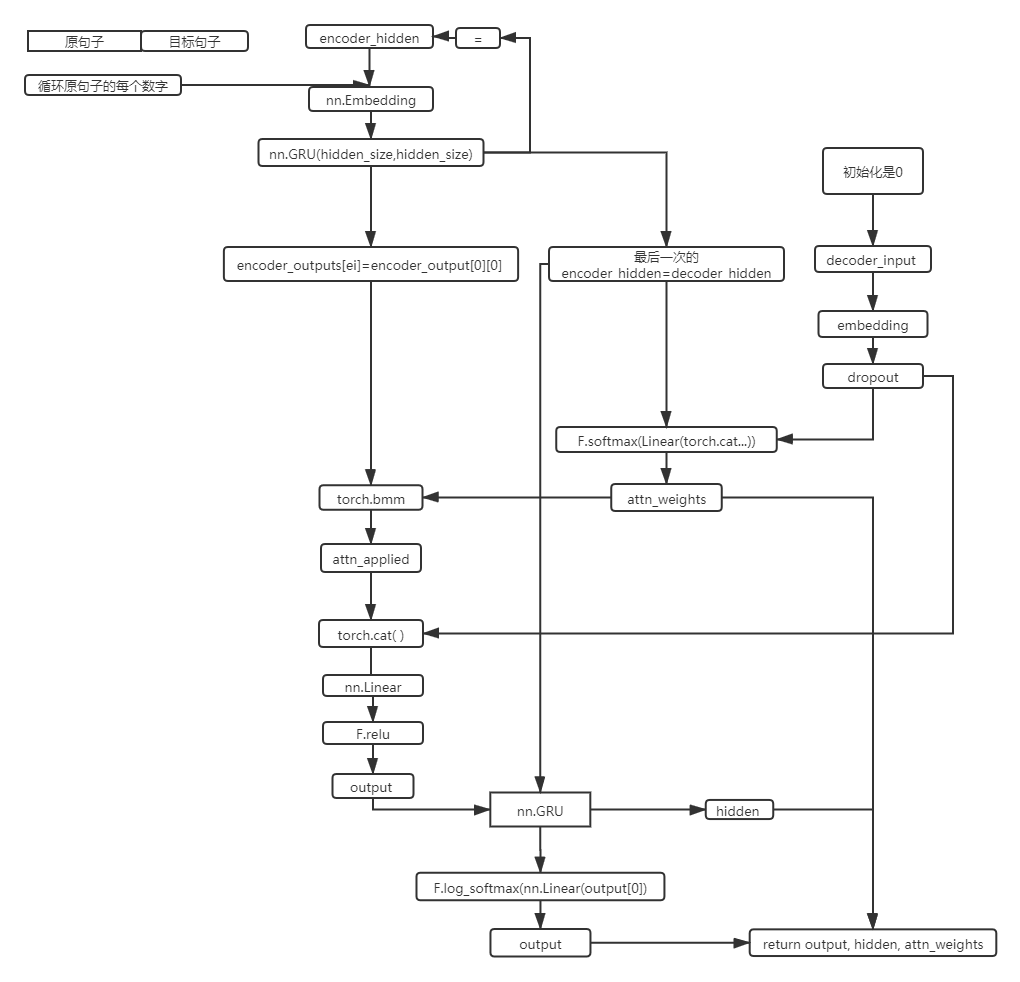

In [108]:
SOS_token = 0
EOS_token = 1
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    #原始数字句子tensor,目标翻译的数字句子tensor  两个模型             两个优化器                损失函数     最大句子长度 超过就要截断     
    encoder_hidden = encoder.initHidden() # 参数矩阵初始化  
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad() 
    
    input_length = input_tensor.size(0)   #取tensor矩阵的第一个维度 也就是这个句子的长度 
    target_length = target_tensor.size(0) #取tensor矩阵的第一个维度 也就是这个句子的长度 
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)  # 全是0的二维tensor 矩阵
    mask = np.zeros((10)) # 构建 mask 矩阵 对于补充地方 值是0 
    loss = 0
    
# 这里的一个思路是这样的 我想为这一个数字序列的句子进行编码：第一次输入 句子的第一个数字 和 gru所需要的 encoder_hidden 初始化是全0的 然后输出的 中间结果
# 赋值为 encoder_hidden 第二次是输入 句子中的第二个数字 ，和上一次结果的输出的 encoder_hidden 然后这样循环 为 句子中的 每个 数字（单词） 复制了向量 。   
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) # encoder就是 EncoderRNN 模型 
        #                                         两个输入的参数   torch.Size([1, 1, 256])  全是0 
        # 输出的 encoder_hidden  形状跟输入的时候是一样的 =torch.Size([1, 1, 256]) 
        # encoder_output 是一个 三维的矩阵 形状是 torch.Size([1, 1, 256]) 
        encoder_outputs[ei]=encoder_output[0][0] # 所以这一步是降维的作用直接取出这个 256长度的向量 
        mask[ei]=1
        
        
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
    decoder_input = torch.tensor(encoder_outputs[input_length-1], device=device) # 取 encoder输出的最后一个 不是全0的 单词的输出 因为全0 就是 后来补上的！
    
    decoder_hidden = encoder_hidden # 整个句子都跑一遍 gru出来的最后的hidden 结果：torch.Size([1, 1, 256])
    
    
    use_teacher_forcing = True if random.random() < 0.5 else False 
    # use_teacher_forcing 是 0.5的概率出现 true 或者 false 
    
    if use_teacher_forcing:
        for di in range(target_length): # target_length 是目标翻译句子的长度 
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs,mask)# mask没用到
            
#  decoder_input：ensor([[0]])，在前边 decoder_hidden = encoder_hidden torch.Size([1, 1, 256]) ，encoder_outputs 前边的数字向量矩阵
#  decoder_output:torch.Size([1, 3228]),decoder_hidden:torch.Size([1, 1, 256]) ,decoder_attention:torch.Size([1, 10])

            loss+=criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]   # Teacher forcing
        
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs,mask)
            
            topv, topi = decoder_output.topk(1)
            # 返回最后一个维度上 的最大值 和索引 ，在这里decoder_output：torch.Size([1, 3228])
            # print(topv, topi): tensor([[-7.6416]], grad_fn=<TopkBackward>) tensor([[1410]])
            
            decoder_input = topi.squeeze().detach() # 这里操作比较麻烦 从这个二维度的tensor中把这个值取出来
            # decoder_input tensor(1185)
            
            loss+=criterion(decoder_output, target_tensor[di])
            if decoder_input.item()==EOS_token:# 假设这个 值是0 说明就是说明结束了 
                break
                
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length


In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [19]:
print(pairs[10000:10002])
print(random.choice(pairs))
print("--------")
print(tensorsFromPair(random.choice(pairs)))
print("--------")
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(75000)]
print(len(training_pairs))
print(training_pairs[10000])
print(training_pairs[10000][0].size(0))

[['je suis desormais pour ainsi dire un expert .', 'i m practically an expert now .'], ['je suis convaincu que tom est serieux .', 'i m pretty sure tom s serious .']]
['je suis en bons termes avec mon frere .', 'i am on good terms with my brother .']
--------
(tensor([[ 131],
        [  14],
        [ 134],
        [  14],
        [ 787],
        [1683],
        [   5],
        [   1]]), tensor([[  81],
        [ 135],
        [ 112],
        [1257],
        [1755],
        [ 841],
        [  48],
        [   4],
        [   1]]))
--------
75000
(tensor([[131],
        [618],
        [  5],
        [  1]]), tensor([[ 81],
        [ 82],
        [117],
        [  4],
        [  1]]))
4


In [116]:
def trainIters(encoder, decoder, n_iters, print_every, plot_every, learning_rate):
    #                             75000,    5000        1000         0.01
    
    start = time.time()
    plot_losses=[]
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0   # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    #                pairs 二维度列表 每个列表中是一个句子对  [['j ai ans .', 'i m .'], ['je vais bien .', 'i m ok .']]
    #                tensorsFromPair(random.choice(pairs)) 随机选择一个句子对 然后把 单词转化成对应的索引   然后每个句子的最后一个单词都是1 
    #                tensorsFromPair(random.choice(pairs)) for i in range(n_iters) 把这个tensorsFromPair(random.choice(pairs)) 操作重复 n_iters次 形成语料库 
    
    criterion = nn.NLLLoss() # 交叉熵计算公式
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1] # 先取一个句子对 
#         print("training_pair",training_pair) 
        input_tensor = training_pair[0] # 把这个句子对(句子对是一个列表) 列表中第一个是法语的句子 句子都是用数字表示的 而且是tensor  
        
        target_tensor = training_pair[1] # 把这个句子对(句子对是一个列表) 列表中第二个是英语的句子  句子都是用数字表示的 而且是tensor  
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total+=loss
        plot_loss_total+=loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [27]:
print(input_lang.n_words)
print(output_lang.n_words)
print(input_lang)

4920
3228


In [117]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device) # 模型定义！
              # input_lang.n_words=4920    
    
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device) # 模型定义！
              #                          output_lang.n_words=3228    

trainIters(encoder1, attn_decoder1, 75000,5000,1000,0.01)


training_pair (tensor([[ 127],
        [  25],
        [ 182],
        [  93],
        [2656],
        [   5],
        [   1]], device='cuda:0'), tensor([[  79],
        [  40],
        [  63],
        [ 112],
        [1593],
        [   4],
        [   1]], device='cuda:0'))
training_pair (tensor([[ 24],
        [148],
        [787],
        [109],
        [275],
        [601],
        [  5],
        [  1]], device='cuda:0'), tensor([[ 14],
        [ 40],
        [202],
        [321],
        [344],
        [  4],
        [  1]], device='cuda:0'))
training_pair (tensor([[  35],
        [ 286],
        [2056],
        [ 275],
        [1799],
        [   5],
        [   1]], device='cuda:0'), tensor([[  14],
        [  40],
        [ 817],
        [ 883],
        [1919],
        [   4],
        [   1]], device='cuda:0'))
training_pair (tensor([[  24],
        [3501],
        [ 449],
        [ 123],
        [ 505],
        [   5],
        [   1]], device='cuda:0'), tensor([[ 14],
       

KeyboardInterrupt: 